In [2]:
from __future__ import print_function, division
import os
from collections import OrderedDict
import logging

import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# Make the plots look pretty
matplotlib.rc('font',size=13)
matplotlib.rc('legend', numpoints=1)
matplotlib.rc('image', cmap='inferno')
matplotlib.rc('image', interpolation='none')
# Use the same color cylcer as Seaborn
from cycler import cycler
color_cycle = [u'#4c72b0', u'#55a868', u'#c44e52', u'#8172b2', u'#ccb974', u'#64b5cd']
matplotlib.rcParams['axes.prop_cycle'] = cycler("color", color_cycle)

import deblender

import lsst.afw.table as afwTable
import lsst.log as log
import lsst.meas.deblender
from lsst.meas.deblender import proximal, display
import lsst.meas.deblender.utils as debUtils

logger = logging.getLogger("lsst.meas.deblender")
logger.setLevel(logging.INFO)
log.setLevel("", log.INFO)

In [246]:
# ring-shaped masks around the peak
def getRingMask(im_shape, peak, outer, inner=0, flatten=False):
    height,width = im_shape
    x,y = np.meshgrid(np.arange(width), np.arange(height))
    r = np.sqrt((x-peak[1])**2 + (y-peak[0])**2)
    mask = (r < inner) | (r >= outer)
    if flatten:
        return mask.flatten()
    return mask

# odd-integer downsampling
def downsample(S, oversampling, mask=None):
    assert isinstance(oversampling, int)
    if oversampling <= 1:
        return S
    else:
        height,width = S.shape
        height = int(height/oversampling)
        width = int(width/oversampling)
        Sd = np.zeros((height, width), dtype=S.dtype)
        if mask is None:
            S_ = S
        else:
            S_ = S*(~mask)
        # TODO: can we avoid the double loop?
        for h in range(height):
            for w in range(width):
                Sd[h,w] = S_[h*oversampling:(h+1)*oversampling, w*oversampling:(w+1)*oversampling].sum() / oversampling**2
        return Sd

# construct spin-wave decomposition operator for given list of spin numbers m
# radial behavior can be specified as appropriate
def getSpinOp(ms, shape, thickness=4, peak=None, oversampling=21, radial_fct=lambda r:1./np.maximum(1,r)):
    """ Spin decomposition operator.

    The operator maps onto a basis function of R(r) exp(i m phi), where phi is
    the polar angle wrt to the peak (or, if None, the center of the image).

    The decomposition is performed in a set of concentric rings of fixed thickness.

    ms is a list of integers that indicate the requested spin numbers.
    thickness is the radial separation between the inner and outer ring radius.
    peak is (an optional) offset of the object from the image center.
    oversampling determine the higher-resolution grid for the in-pixel
    integration; it must be odd.
    radial_fct is the radial part of the spin basis function.

    """
    assert oversampling % 2 == 1
    assert hasattr(ms, '__iter__')

    height,width = shape
    assert height % 2 == 1 and width % 2 == 1

    if peak is None:
        peak = [int(height/2), int(width/2)]
    x,y = np.meshgrid(np.arange(width*oversampling), np.arange(height*oversampling))
    x = x * 1./oversampling - peak[1]
    y = y * 1./oversampling - peak[0]
    # proper treatment of over & downsampling: center pixel location
    if oversampling > 1:
        x -= 0.5 - 0.5/oversampling
        y -= 0.5 - 0.5/oversampling
    # convert to polar
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y,x)

    # define series of radial ring-shaped masks (oversampled as well)
    r_limit = (np.min([peak[0], height-peak[0], peak[1], width-peak[1]]) - 1)*oversampling
    base = thickness*oversampling
    lims = [(base*(i+1), base*i) for i in range(int(r_limit/base))]
    mask_peak = ((peak[0]+0.5)*oversampling - 0.5, (peak[1]+0.5)*oversampling - 0.5)
    masks = [getRingMask(r.shape, mask_peak, outer, inner) for outer, inner in lims]

    Ss = []
    for i in range(len(ms)):
        m = ms[i]
        spin = radial_fct(r) * np.exp(1j*m*phi)
        S = downsample(spin, oversampling).flatten()
        Ss.append(S)
        continue
        
        for j in range(len(masks)):
            mask = masks[j]
            #S = downsample(spin, oversampling, mask=mask)
            #plt.imshow(np.real(S))
            #plt.show()
            #plt.imshow(np.imag(S))
            #plt.show()
            S = downsample(spin, oversampling, mask=mask).flatten()
            Ss.append(S)

    # TODO: make Ss sparse and split real and imaginary part
    return np.array(Ss)


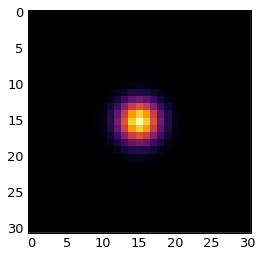

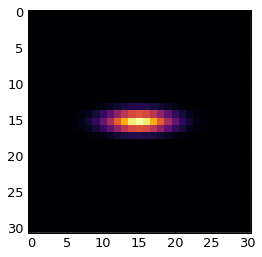

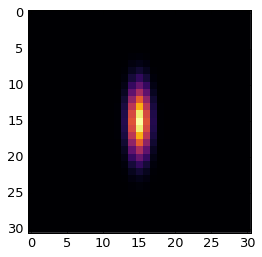

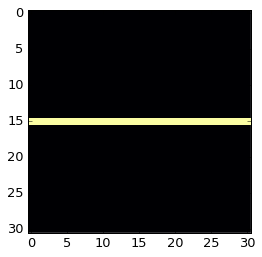

In [265]:
#ms=[1,3,4,5,6,7,8]
ms=[2,4,6,8]
shape = (31,31)
spinOp = getSpinOp(ms, shape=shape, radial_fct=lambda r:1)

def gaussian2D(x, y, x0=0, y0=0, A=10, sigmaX=2, sigmaY=2):
    return A*np.exp(-0.5*(((x-x0)**2)/sigmaX+((y-y0)**2)/sigmaY))
def getGaussian(shape, x0=0, y0=0, A=1, sigmaX=2, sigmaY=2):
    xRadius = int(0.5*shape[1])
    yRadius = int(0.5*shape[0])
    x = np.arange(shape[1])-xRadius
    y = np.arange(shape[0])-yRadius
    x,y = np.meshgrid(x,y)
    return gaussian2D(x, y, x0, y0, A, sigmaX, sigmaY)

img1 = getGaussian(shape, sigmaX=4, sigmaY=4)
plt.imshow(img1)
plt.show()

img2 = getGaussian(shape, sigmaX=10, sigmaY=1)
plt.imshow(img2)
plt.show()

img3 = getGaussian(shape, sigmaX=1, sigmaY=10)
plt.imshow(img3)
plt.show()

img4 = np.zeros(shape)
img4[int((shape[0]-1)/2)] = 10
plt.imshow(img4)
plt.show()

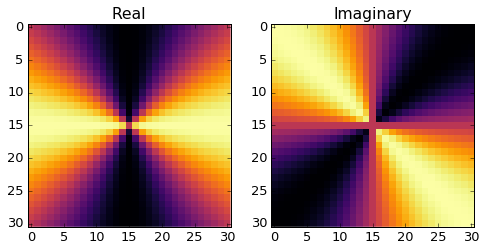

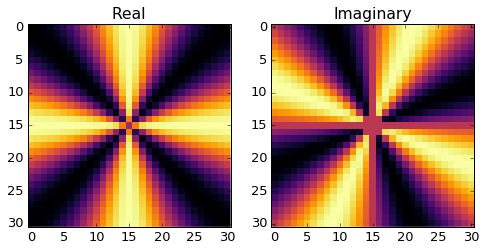

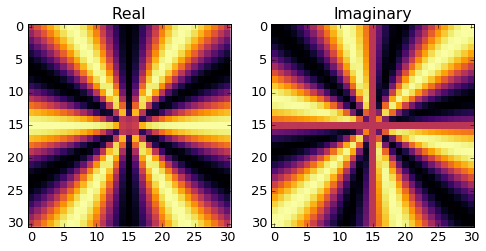

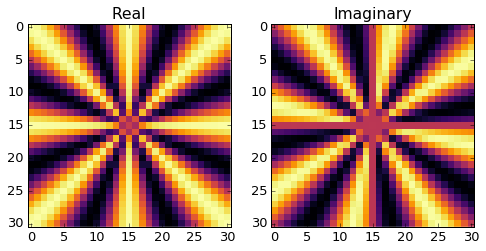

In [266]:
outer = spinOp#spinOp[1::3]
for S in outer:
    fig = plt.figure(figsize=(8,4))
    axR = fig.add_subplot(1,2,1)
    axI = fig.add_subplot(1,2,2)
    axR.imshow(np.real(S).reshape(shape))
    axR.set_title("Real")
    axI.imshow(np.imag(S).reshape(shape))
    axI.set_title("Imaginary")
    plt.show()

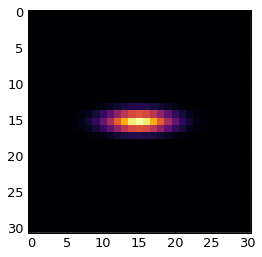

INFO:lsst.meas.deblender:Img-spin 2: 9.764199149226634


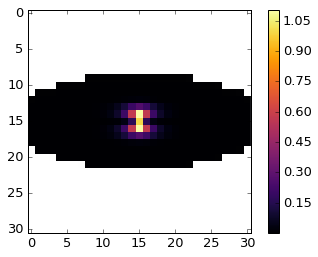

INFO:lsst.meas.deblender:Spin 2
INFO:lsst.meas.deblender:Real: 1.01e+01, Im: 2.27e-03


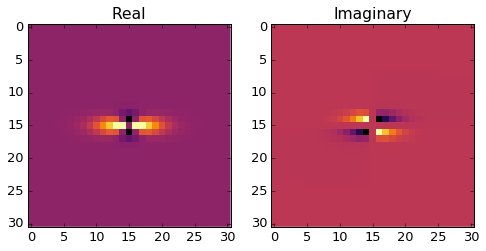

INFO:lsst.meas.deblender:Spin 4
INFO:lsst.meas.deblender:Real: 5.20e+00, Im: -1.76e-16


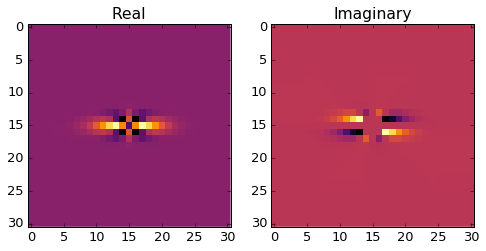

INFO:lsst.meas.deblender:Spin 6
INFO:lsst.meas.deblender:Real: 2.71e+00, Im: -2.27e-03


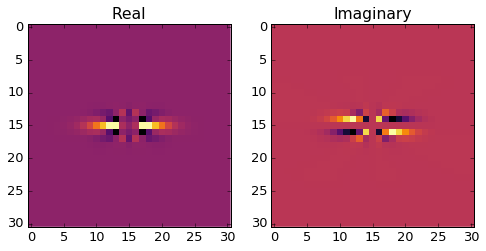

INFO:lsst.meas.deblender:Spin 8
INFO:lsst.meas.deblender:Real: 1.50e+00, Im: -1.97e-16


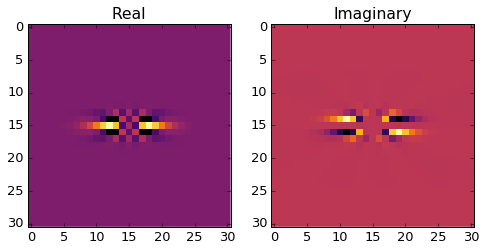

In [283]:
#img = img1
img = img2
#img = img2+img3
#img = img4

plt.imshow(img)
plt.show()

px = int((shape[1]-1)/2)
py = int((shape[0]-1)/2)
peak = np.zeros_like(img)
peak[:,px] = img[:,px]
peak[py,:] = img[py,:]

sub = ((img).flatten()-(img).flatten()*np.real(outer[0])).reshape(shape)
plt.imshow(np.ma.array(sub, mask=np.abs(sub)<1e-9))
logger.info("Img-spin 2: {0}".format(np.sum(sub)))
plt.colorbar()
plt.show()

for s,S in enumerate(outer):
    real = (np.real(S)*img.flatten()).reshape(shape)
    im = (np.imag(S)*img.flatten()).reshape(shape)
    
    logger.info("Spin {0}".format(ms[s]))
    logger.info("Real: {0:.2e}, Im: {1:.2e}".format(np.sum(real), np.sum(im)))
    fig = plt.figure(figsize=(8,4))
    axR = fig.add_subplot(1,2,1)
    axI = fig.add_subplot(1,2,2)
    axR.imshow(real)
    axR.set_title("Real")
    axI.imshow(im)
    axI.set_title("Imaginary")
    plt.show()

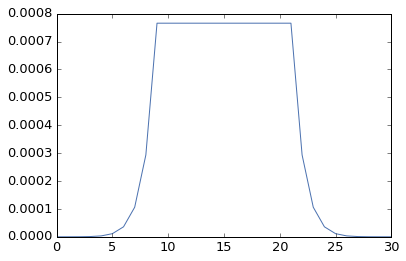

In [294]:
sub[py,px-5:px+6] = sub[py,px+6]
plt.plot(sub[py,:])
plt.show()

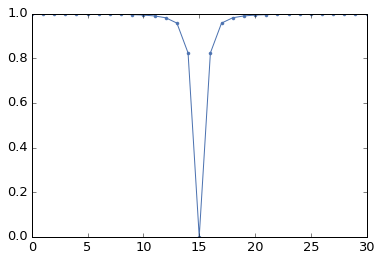

In [289]:
plt.plot(np.real(outer[0]).reshape(shape)[py,:], '.-')
plt.show()

In [228]:
for s,S in enumerate(outer):
    print("Spin {0}: {1:.2e}".format(ms[s], np.sum(np.real(S))))
    print("Spin {0} times circular Gaussian: {1:.2e}".format(ms[s], np.real(S).dot(img2.flatten())))
    print("Spin {0} times elliptical Gaussian: {1:.2e}".format(ms[s], np.real(S).dot(img1.flatten())))
    print("Spin {0} times Gaussian cross: {1:.2e}".format(ms[s], np.real(S).dot((img2+img3).flatten())))
    
    print("Im, Spin {0} times circular Gaussian: {1:.2e}".format(ms[s], np.imag(S).dot(img2.flatten())))
    print("Im, Spin {0} times elliptical Gaussian: {1:.2e}".format(ms[s], np.imag(S).dot(img1.flatten())))
    print("Im, Spin {0} times Gaussian cross: {1:.2e}".format(ms[s], np.imag(S).dot((img2+img3).flatten())))

Spin 2: 3.33e-16
Spin 2 times circular Gaussian: 7.45e-01
Spin 2 times elliptical Gaussian: -4.46e-17
Spin 2 times Gaussian cross: -4.11e-17
Im, Spin 2 times circular Gaussian: 1.39e-18
Im, Spin 2 times elliptical Gaussian: 9.34e-18
Im, Spin 2 times Gaussian cross: 5.45e-18
Spin 4: -1.67e-03
Spin 4 times circular Gaussian: 5.41e-01
Spin 4 times elliptical Gaussian: 9.92e-03
Spin 4 times Gaussian cross: 1.08e+00
Im, Spin 4 times circular Gaussian: -1.01e-18
Im, Spin 4 times elliptical Gaussian: 6.29e-19
Im, Spin 4 times Gaussian cross: 2.86e-18
Spin 6: -2.50e-16
Spin 6 times circular Gaussian: 3.34e-01
Spin 6 times elliptical Gaussian: 1.92e-18
Spin 6 times Gaussian cross: 5.95e-17
Im, Spin 6 times circular Gaussian: 3.72e-18
Im, Spin 6 times elliptical Gaussian: 1.14e-17
Im, Spin 6 times Gaussian cross: 5.71e-18
Spin 8: 4.64e-03
Spin 8 times circular Gaussian: 1.82e-01
Spin 8 times elliptical Gaussian: 1.36e-02
Spin 8 times Gaussian cross: 3.64e-01
Im, Spin 8 times circular Gaussian: 1

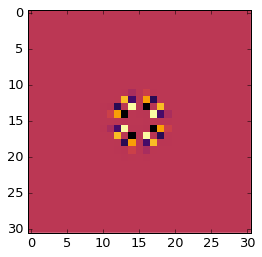

In [207]:
S = spinOp[0]
plt.imshow((np.real(S)*np.imag(S)).reshape(shape))

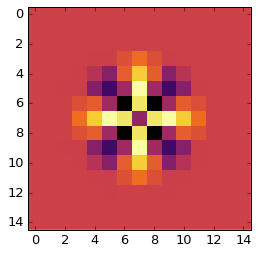

In [186]:
S = spinOp[0]
plt.imshow(np.real(S).reshape(shape))
plt.show()

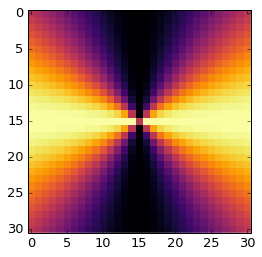

In [301]:
xRadius = int(0.5*shape[1])
yRadius = int(0.5*shape[0])
x = np.arange(shape[1])-xRadius
y = np.arange(shape[0])-yRadius
x,y = np.meshgrid(x,y)
r = np.sqrt(x**2 + y**2)
phi = np.arctan2(y,x)

m = 2
S = np.exp(1j*m*phi)
S[yRadius, xRadius] = 0
plt.imshow(np.real(S))

In [302]:
np.sum(S.real)

-2.8421709430404007e-14

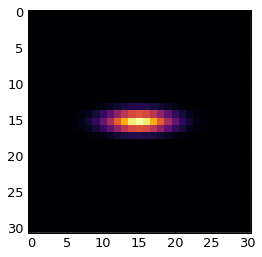

In [304]:
plt.imshow(img)

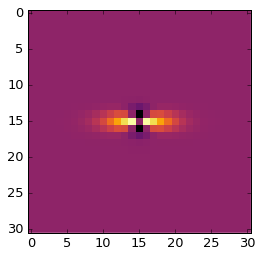

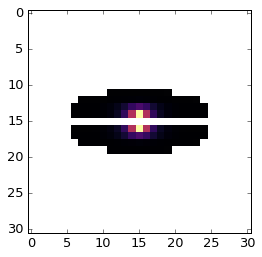

In [323]:
plt.imshow(S.real*img)
plt.show()

t = img-peak-S.real*img
plt.imshow(np.ma.array(t, mask=np.abs(t)<1e-4))
plt.show()

In [317]:
peak = np.zeros_like(img)
peak[yRadius, xRadius] = img[yRadius, xRadius]
np.sum(img-peak-S.real*img)

8.4768846139545708

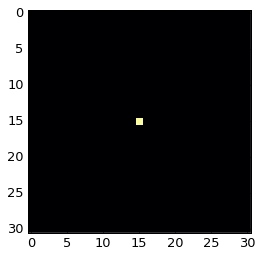

In [316]:

plt.imshow(peak)

In [318]:
np.sum(img-S.real*img)

9.4768846139545708